In [1]:
import mlfinlab
import pandas as pd
import yfinance as yf
from mlfinlab.portfolio_optimization.tic import TIC
from datetime import datetime, timedelta
import pypfopt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns,plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and (not y%100==0 or y%400 == 0) else 28,
        31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)

END_DATE = datetime.today() - timedelta(days = 1) #END_DATE is set to yesterday

In [3]:
##For Asset Class

In [4]:

# TLT : iShares 20 Plus Year Treasury Bond ETF
# SPY : SPDR S&P 500 ETF Trust (SPY)
# LQD : iShares iBoxx $ Investment Grade Corporate Bond ETF
# 0P0000P1BG.F : Vanguard Euro Government Bond Index Fund Investor EUR Accumulation
# EXSA.DE : iShares STOXX Europe 600 UCITS ETF
# 0P00000RNA.F : iShares Euro Credit Bond Index Fund 

data = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Asset Class":[215,225,235,215,225,235],
       "Structure":[2,2,2,2,2,2],}
df = pd.DataFrame(data)





#The numbers in table just represent the category of asset class, They do not matter as long as they are consistent
#Structure column is just added because the code must have 2 columns to evaluate TIC matrix
#Here, Government Bond : Code 15 ; Equity : Code 25; Corporate Bond : Code 35
    

df

,Ticker,Asset Class,Structure
0,TLT,215,2
1,SPY,225,2
2,LQD,235,2
3,0P0000P1BG.F,215,2
4,EXSA.DE,225,2
5,0P00000RNA.F,235,2


In [5]:

data_opt = yf.download("TLT SPY LQD  0P0000P1BG.F EXSA.DE 0P00000RNA.F ", monthdelta(END_DATE,-34), monthdelta(END_DATE,-1))
data_opt = data_opt["Adj Close"]

print(data_opt.head())
print(data_opt.tail())

[*********************100%***********************]  6 of 6 completed
            0P00000RNA.F  0P0000P1BG.F    EXSA.DE         LQD         SPY  \
Date                                                                        
2018-01-24    209.649002     22.254000  37.084473  109.346245  268.878113   
2018-01-25    209.337006     22.228001  36.886639  109.901611  268.992096   
2018-01-26    209.179993     22.212000  37.060917  109.755966  272.106415   
2018-01-29    208.445007     22.155001  37.004398  109.464622  270.302399   
2018-01-30    208.671005     22.166000  36.698231  109.091309  267.529877   

                   TLT  
Date                    
2018-01-24  115.555565  
2018-01-25  116.504135  
2018-01-26  116.072121  
2018-01-29  115.264427  
2018-01-30  114.588219  
            0P00000RNA.F  0P0000P1BG.F    EXSA.DE         LQD         SPY  \
Date                                                                        
2020-10-19    233.796005     23.886999  36.264999  134.794144 

In [6]:
import statistics 
stock_returns = expected_returns.mean_historical_return(data_opt, frequency = 252)
print(stock_returns)
daily_returns = expected_returns.returns_from_prices(data_opt, log_returns=False)


#std using data_opt
std_ticker = []
for key in range(stock_returns.shape[0]):
    std_ticker.append(daily_returns.iloc[:, key].std())
print(std_ticker)


# the std from previous stock_returns:
## [0.0012216519545923833, 0.0006683449676765178, 0.010144403354237932, 0.0028127929491171184, 0.012318830492028499, 0.006096298839254111]
## stdev from for loop from data_opt [1.6483297807040278, 0.12883503980851368, 0.5195598097552299, 1.388615456983342, 13.066622616080572, 3.0388625896015524]

0P00000RNA.F    0.037950
0P0000P1BG.F    0.024740
EXSA.DE        -0.012108
LQD             0.075896
SPY             0.093525
TLT             0.117211
dtype: float64
[0.002445029689269789, 0.0014875772949388736, 0.012147454336408818, 0.006707259500765075, 0.014598185057687315, 0.0096257208550916]


In [7]:


# Calculating the empirical correlation matrix
#corr_matrix = data_opt.corr()
corr_matrix = daily_returns.corr()
print(corr_matrix)


# Calculating the relation of sample length T to the number of variables N
# It's used for de-noising the TIC matrix
#tn_relation = data_opt.shape[0] / data_opt.shape[1]
tn_relation = daily_returns.shape[0]/daily_returns.shape[1]
print("tn_relation is: ", tn_relation)

# The class that contains the TIC algorithm
tic = TIC()

# Calculating the Theory-Implied Correlation matrix
tic_matrix = pd.DataFrame(tic.tic_correlation(df, corr_matrix, tn_relation, kde_bwidth=0.01))



# Calculating the distance between the empirical and the theory-implied correlation matrices
matrix_distance = tic.corr_dist(corr_matrix, tic_matrix)
print("distance is: ", matrix_distance)

              0P00000RNA.F  0P0000P1BG.F   EXSA.DE       LQD       SPY  \
0P00000RNA.F      1.000000      0.732458  0.074872  0.224066  0.016177   
0P0000P1BG.F      0.732458      1.000000  0.049644  0.396190  0.059834   
EXSA.DE           0.074872      0.049644  1.000000  0.237296  0.659736   
LQD               0.224066      0.396190  0.237296  1.000000  0.280758   
SPY               0.016177      0.059834  0.659736  0.280758  1.000000   
TLT               0.394807      0.396223 -0.296411  0.380383 -0.448204   

                   TLT  
0P00000RNA.F  0.394807  
0P0000P1BG.F  0.396223  
EXSA.DE      -0.296411  
LQD           0.380383  
SPY          -0.448204  
TLT           1.000000  
tn_relation is:  118.16666666666667
distance is:  0.07959612893090928


In [8]:
##For Country

In [9]:

# TLT : iShares 20 Plus Year Treasury Bond ETF
# SPY : SPDR S&P 500 ETF Trust (SPY)
# LQD : iShares iBoxx $ Investment Grade Corporate Bond ETF
# 0P0000P1BG.F : Vanguard Euro Government Bond Index Fund Investor EUR Accumulation
# EXSA.DE : iShares STOXX Europe 600 UCITS ETF
# 0P00000RNA.F : iShares Euro Credit Bond Index Fund 


data2 = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Country":[115,115,115,125,125,125],
       "Structure":[1,1,1,1,1,1]}

#The numbers in table just represent the category of asset class, They do not matter as long as they are consistent
#Structure column is just added because the code must have 2 columns to evaluate TIC matrix
#Here, USA : Code 15 ; Europe : Code 25

df2 = pd.DataFrame(data2)

In [10]:

# The class that contains the TIC algorithm
tic2 = TIC()

# Calculating the Theory-Implied Correlation matrix
tic_matrix_2 = pd.DataFrame(tic2.tic_correlation(df2, corr_matrix, tn_relation, kde_bwidth=0.01))



# Calculating the distance between the empirical and the theory-implied correlation matrices
matrix_distance2 = tic2.corr_dist(corr_matrix, tic_matrix_2)
print(matrix_distance2)

0.1449461262018743


In [11]:
big_tic = (tic_matrix+tic_matrix_2)/2
print(big_tic)
print(std_ticker)

          0         1         2         3         4         5
0  1.000000  0.476956  0.104699  0.347600  0.205802  0.358111
1  0.476956  1.000000  0.102607  0.358111  0.203710  0.369262
2  0.104699  0.102607  1.000000  0.237809  0.411875  0.235717
3  0.347600  0.358111  0.237809  1.000000  0.254401  0.418366
4  0.205802  0.203710  0.411875  0.254401  1.000000  0.252309
5  0.358111  0.369262  0.235717  0.418366  0.252309  1.000000
[0.002445029689269789, 0.0014875772949388736, 0.012147454336408818, 0.006707259500765075, 0.014598185057687315, 0.0096257208550916]


In [12]:
big_tic_cov = pypfopt.risk_models.corr_to_cov(big_tic,std_ticker)*252
tic_cov1 = pypfopt.risk_models.corr_to_cov(tic_matrix,std_ticker)*252
tic_cov2 = pypfopt.risk_models.corr_to_cov(tic_matrix_2,std_ticker)*252
print(big_tic_cov)

          0         1         2         3         4         5
0  0.001506  0.000437  0.000784  0.001437  0.001851  0.002124
1  0.000437  0.000558  0.000467  0.000900  0.001115  0.001332
2  0.000784  0.000467  0.037185  0.004883  0.018406  0.006946
3  0.001437  0.000900  0.004883  0.011337  0.006277  0.006807
4  0.001851  0.001115  0.018406  0.006277  0.053703  0.008934
5  0.002124  0.001332  0.006946  0.006807  0.008934  0.023349


In [24]:
#Plotting the efficient frontir and hypothetical universes
import numpy as np
import random
import matplotlib.pyplot as plt

    
#Expected returns and volatility for an efficient frontier portfolio
def optimisation(target_returns, covariance, returns):
    # Optimise mean - variance to get weights for initialising investment process
    ef = EfficientFrontier(returns, covariance)
    raw_weights = ef.efficient_return(target_returns)
    cleaned_weights = ef.clean_weights()
    cleaned_weights = np.array(list(cleaned_weights.values()))
    
    variance = np.dot(cleaned_weights.T, np.dot(covariance, cleaned_weights))
    vol = np.sqrt(variance)
    expected_returns = np.dot(returns, cleaned_weights).sum()
    return vol, expected_returns


#loop for for all the portfolios in efficient frontier
def all_efficient_frontier_portfolios(returns, covariance):
    
    ef = EfficientFrontier(returns, covariance )
    target_returns = np.linspace(0, ef.expected_returns.max(), 100)
    frontier_volatility = []
    frontier_returns = []
    
    for portfolio in range(len(target_returns)):
        frontier_data = optimisation(target_returns[portfolio], covariance, returns)
        frontier_volatility.append(frontier_data[0])
        frontier_returns.append(frontier_data[1])
        #print(target_returns[portfolio],frontier_data[1])
    return frontier_returns, frontier_volatility



#Hypothetical universes
def hypothetical_portfolios(num_of_portfolios, stock_returns, covariance):
    
    p_ret = []
    p_vol = []
    for portfolio in range(num_of_portfolios):
        
        weights = np.random.randint(low=0, high=9, size=6)
        weights = weights/np.sum(weights)
        returns = np.dot(stock_returns, weights).sum()
        var = np.dot(weights, np.dot(covariance, weights.T))
        std = np.sqrt(var)
        p_ret.append(returns)
        p_vol.append(std)
    return p_ret, p_vol


def plot_efficient_frontier(stock_returns, covariance, num_universes, title):
    
    tic_ef = all_efficient_frontier_portfolios(stock_returns, covariance)
    tic_universe = hypothetical_portfolios(num_universes, stock_returns, covariance)
 
    plt.figure(figsize=(12,8))
    plt.scatter(tic_universe[1], tic_universe[0], s=10, label='Hypothetical Portfolios')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.plot(tic_ef[1],tic_ef[0], 'r--', linewidth=2, label='Efficient Frontier')
    plt.title(title)
    plt.legend()
    ##ax.savefig('cover.png')

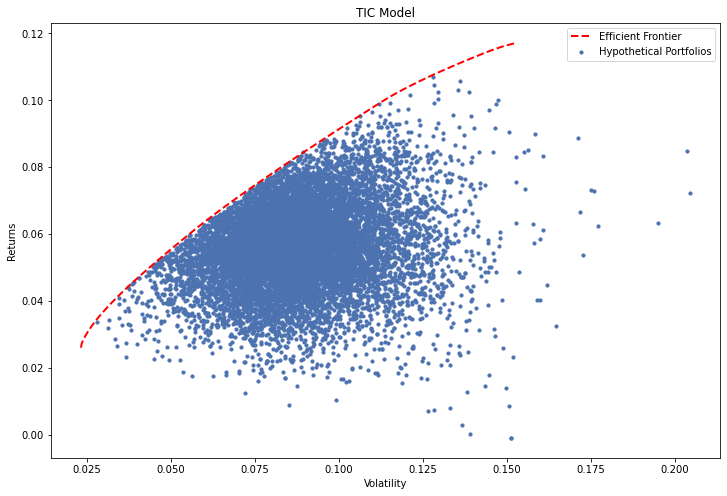

In [25]:
# Plotting efficient frontier for the combined TIC model
plot_efficient_frontier(stock_returns, big_tic_cov, num_universes=12000, title='TIC Model')


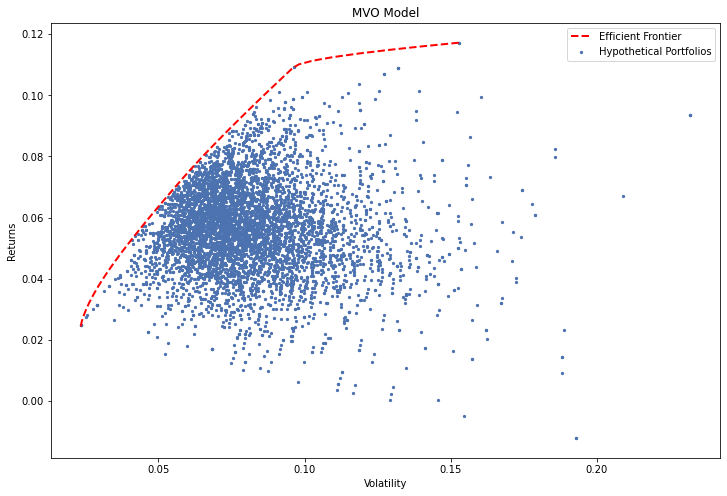

In [15]:
# Plotting efficient frontier for empirical covariance
covariance = risk_models.sample_cov(data_opt, returns_data=False, frequency=252)
plot_efficient_frontier(stock_returns, covariance, 6000, title='MVO Model')

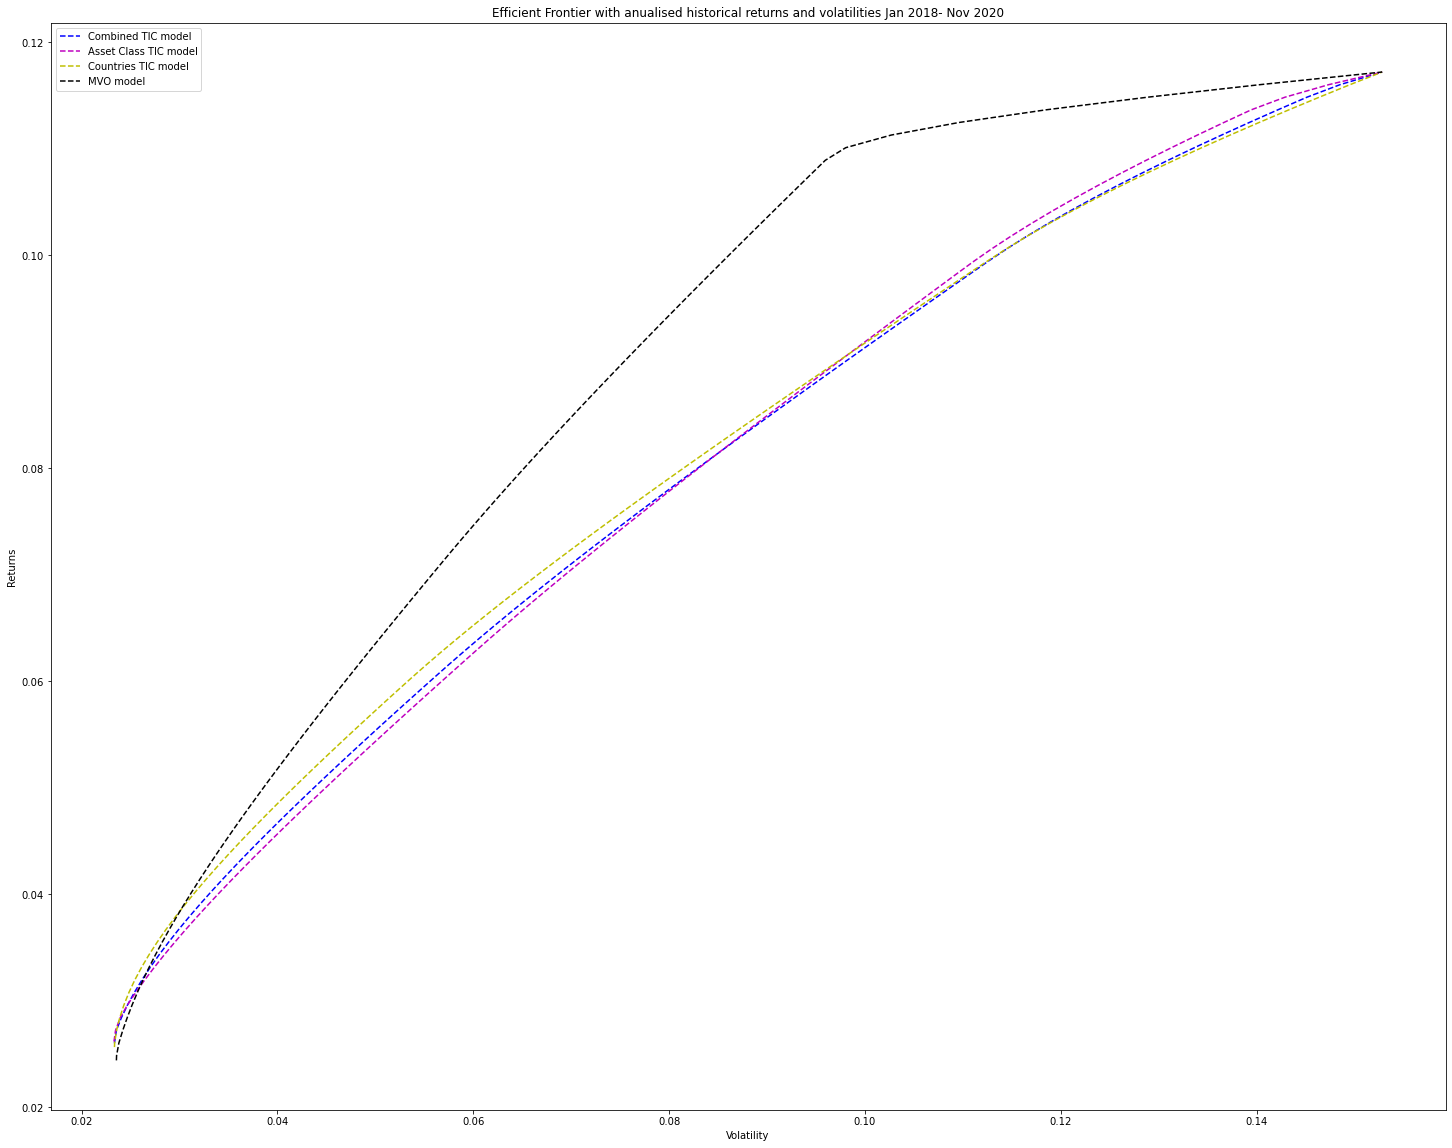

In [16]:
tic_ef0 = all_efficient_frontier_portfolios(stock_returns, big_tic_cov)
tic_ef1 = all_efficient_frontier_portfolios(stock_returns, tic_cov1)
tic_ef2 = all_efficient_frontier_portfolios(stock_returns, tic_cov2)
tic_ef3 = all_efficient_frontier_portfolios(stock_returns, covariance)

 
plt.figure(figsize=(25, 20))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.plot(tic_ef0[1],tic_ef0[0], 'b--', linewidth=1.5, label='Combined TIC model')
plt.plot(tic_ef1[1],tic_ef1[0], 'm--', linewidth=1.5, label='Asset Class TIC model')
plt.plot(tic_ef2[1],tic_ef2[0], 'y--', linewidth=1.5, label='Countries TIC model')
plt.plot(tic_ef3[1],tic_ef3[0], 'k--', linewidth=1.5, label='MVO model')

plt.title("Efficient Frontier with anualised historical returns and volatilities Jan 2018- Nov 2020")
plt.legend()
plt.show()

In [17]:
#showing we need to multiply by len(data_opt) to get correct covariance
print(covariance)
print(pypfopt.risk_models.corr_to_cov(corr_matrix,std_ticker)*252)

              0P00000RNA.F  0P0000P1BG.F   EXSA.DE       LQD       SPY  \
0P00000RNA.F      0.001506      0.000671  0.000560  0.000926  0.000146   
0P0000P1BG.F      0.000671      0.000558  0.000226  0.000996  0.000327   
EXSA.DE           0.000560      0.000226  0.037185  0.004872  0.029482   
LQD               0.000926      0.000996  0.004872  0.011337  0.006928   
SPY               0.000146      0.000327  0.029482  0.006928  0.053703   
TLT               0.002342      0.001430 -0.008734  0.006189 -0.015871   

                   TLT  
0P00000RNA.F  0.002342  
0P0000P1BG.F  0.001430  
EXSA.DE      -0.008734  
LQD           0.006189  
SPY          -0.015871  
TLT           0.023349  
              0P00000RNA.F  0P0000P1BG.F   EXSA.DE       LQD       SPY  \
0P00000RNA.F      0.001506      0.000671  0.000560  0.000926  0.000146   
0P0000P1BG.F      0.000671      0.000558  0.000226  0.000996  0.000327   
EXSA.DE           0.000560      0.000226  0.037185  0.004872  0.029482   
LQD       

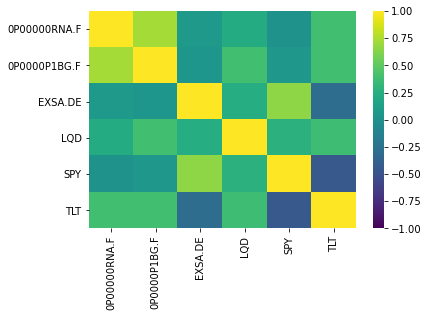

In [18]:
import seaborn
seaborn.heatmap(corr_matrix, cmap='viridis', vmin=-1, vmax=1)

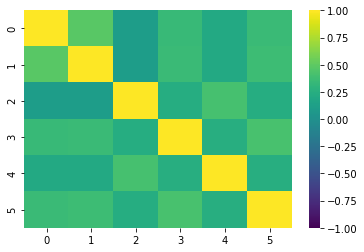

In [19]:
seaborn.heatmap(big_tic, cmap='viridis', vmin=-1, vmax=1)
##visibly less noisy with TIC